In [17]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpy.linalg import norm
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import pickle

import gdown
%matplotlib inline

INPUT_DIR = "/kaggle/input/"
OUTPUT_DIR = "/kaggle/output"

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
# Simple tokenizer -> Rewrite
class MyTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        return [x.lower() for x in re.findall(r'\w+', text)]

    def encode(self, text):
        tokens = [self.word2ind.get(word, self.word2ind['<unk>']) for word in self.tokenize(text)]
        return tokens

In [20]:
tokenizer = MyTokenizer()

In [21]:
train_data = np.array(pd.read_csv(f"{INPUT_DIR}/hack-data/train.csv"))
test_data = np.array(pd.read_csv(f"{INPUT_DIR}/hack-data/test.csv"))

In [22]:
def show_item(ind, data):
  print("Id: ", data[ind][0])
  print("Text: ", data[ind][1])
  print("Source: ", data[ind][2])


show_item(1, train_data)
print(len(train_data))
print(len(test_data))

Id:  198426
Text:  Слева от меня Алексей Ильмухин. Путешественник и интересный человек. В числе его личных побед - путешествие на велосипеде от Челябинска до Байкала... Приехал к нам помочь в организации семинара Мухтара. Просто взял и приехал из Челябинска и начал помогать... ))👍 #можеткаждый
Source:  rusentiment
232366
58092


In [23]:
# print(pd.read_csv(f"{BASE_DIR}/Hack&Change/train.csv").head())

In [24]:
# Creating vocabulary
words = Counter()

for i in range(len(train_data)):
  proccessed_text = train_data[i][1].lower().translate(str.maketrans('', '', string.punctuation))

  for word in word_tokenize(proccessed_text):
    words[word] += 1

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 5

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Vocabulary length: {len(vocab)}')

Vocabulary length: 87012


In [25]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [26]:
class CustomDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx):
        processed_text = tokenizer.tokenize(self.data[idx][1])
        source = self.data[idx][2]

        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in processed_text
        ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "source": source,
            "label": self.data[idx][3]
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch, pad_id=word2ind['<pad>'], max_len=256):
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [27]:
X_train, X_val = train_test_split(train_data, test_size=0.1, shuffle=False)

train_dataset = CustomDataset(X_train)
val_dataset = CustomDataset(X_val)

batch_size = 25
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

val_dataloader = DataLoader(
    val_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [28]:
def F1macro(model, val_dataloader) -> float:
    predictions = []
    target = []
    model.eval()

    with torch.no_grad():
        for batch in val_dataloader:
            logits = model(batch['input_ids'].to(device))
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'].to(device))

    predictions = torch.cat(predictions).cpu().numpy()
    target = torch.cat(target).cpu().numpy()

    macro_f1 = f1_score(predictions, target, average='macro')

    return macro_f1

def accuracy(model, val_dataloader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

In [29]:
class BaseModel(nn.Module):
    def __init__(
        self, hidden_dim, vocab_size, num_classes,
        aggregation_type: str = 'max', lstm_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.LSTM(hidden_dim, hidden_dim, num_layers=lstm_layers, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2 * 2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _Ве = self.gru(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        elif self.aggregation_type == 'max+mean':
            max_pool = output.max(dim=1)[0]
            mean_pool = output.mean(dim=1)

            output = torch.cat([max_pool, mean_pool], dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction

In [30]:
def train(model, optimizer, epochs, criterion, train_loader, val_loader):
    train_losses = []
    val_losses = []

    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        train_losses_per_epoch = []
        val_losses_per_epoch = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch in pbar:
            optimizer.zero_grad()

            logits = model(batch['input_ids'].to(device))
            loss = criterion(logits, batch['label'])

            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        with torch.no_grad():
            model.eval()
            for batch in val_loader:
                logits = model(batch['input_ids'].to(device))
                loss = criterion(logits, batch['label'])

                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

        print(f"Epoch {epoch+1}/{epochs} | "
              f"train_loss={train_losses[-1]:.2f} | "
              f"val_loss={val_losses[-1]:.2f} | "
              f"F1-micro={F1macro(model, val_dataloader)} | "
              f"Accuracy={accuracy(model, val_dataloader)}")

    return train_losses, val_losses

In [31]:
model = BaseModel(
    hidden_dim=256,
    vocab_size=len(vocab),
    num_classes=3,
    lstm_layers=2,
    aggregation_type='max+mean'
    ).to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
epochs = 4

train_losses, val_losses = train(model, optimizer, epochs, criterion, train_dataloader, val_dataloader)

Epoch 1/4:   0%|          | 0/8366 [00:00<?, ?it/s]

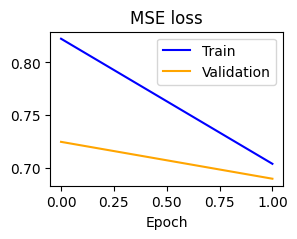

In [19]:
plt.figure(figsize=(3, 2))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train', color='blue')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation', color='orange')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()


In [2]:
save_data = [model, word2ind]

os.makedirs(OUTPUT_DIR, exist_ok=True)

with open(f"{OUTPUT_DIR}/save_data.pkl", "wb") as f:
  pickle.dump(save_data, f)

NameError: name 'model' is not defined

In [1]:
ls

In [ ]:
import os
!git push origin HEAD
os.chdir("hack-change-2025")